### 1. Problem statement
 - Test set -> UA stock from 2019-01-01 to 2020-12-31

### 2. Import library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

##### 2.1 Download relevant stock data

In [2]:
UA = yf.Ticker("UAL")
DA = yf.Ticker("DAL")
AA = yf.Ticker("AAL")

In [4]:
# Download stock data then export as CSV
data_df = yf.download("UAL", start="2010-01-01", end="2021-12-31")
data_df.to_csv('UAL.csv')

[*********************100%***********************]  1 of 1 completed


In [5]:
# Download stock data then export as CSV
data_df = yf.download("DAL", start="2010-01-01", end="2021-12-31")
data_df.to_csv('DAL.csv')

[*********************100%***********************]  1 of 1 completed


In [8]:
# Download stock data then export as CSV
data_df = yf.download("AAL", start="2010-01-01", end="2021-12-31")
data_df.to_csv('AAL.csv')

[*********************100%***********************]  1 of 1 completed


In [7]:
data_df.shape
data_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,4.840000,4.940000,4.660000,4.770000,4.496877,9837300
2010-01-05,4.790000,5.370000,4.710000,5.310000,5.005957,25212000
2010-01-06,5.190000,5.380000,5.000000,5.090000,4.798554,16597900
2010-01-07,5.060000,5.430000,5.050000,5.240000,4.939964,14033400
2010-01-08,5.270000,5.430000,5.060000,5.140000,4.845691,12760000
...,...,...,...,...,...,...
2021-12-23,18.590000,18.719999,18.150000,18.260000,18.260000,32321000
2021-12-27,17.660000,18.240000,17.549999,18.170000,18.170000,28059300
2021-12-28,18.030001,18.639999,17.920000,18.540001,18.540001,28263600


### 3. Data processing

#### 3.0 import the data

In [5]:
dataset_train = pd.read_csv('UA_stock.csv')

In [6]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,81.690002,84.290001,81.410004,84.180000,84.180000,2973400
1,2019-01-03,83.260002,83.260002,78.379997,80.000000,80.000000,6426200
2,2019-01-04,80.879997,83.949997,80.769997,82.680000,82.680000,3808300
3,2019-01-07,82.570000,83.919998,81.449997,83.230003,83.230003,2653000
4,2019-01-08,83.300003,84.620003,81.889999,82.379997,82.379997,3910000


In [7]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values

In [8]:
training_set.shape

(504, 1)

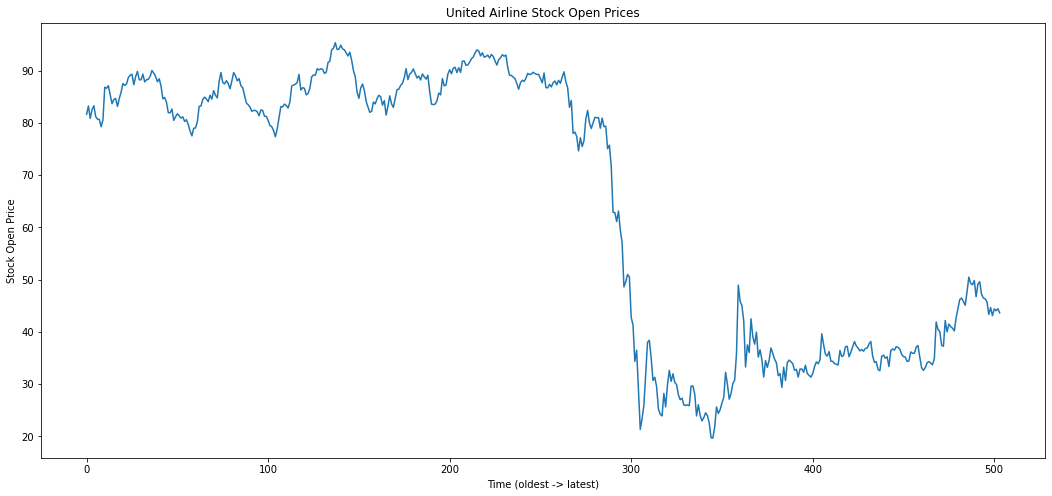

In [9]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("United Airline Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

#### 3.1 Feature scaling

In [10]:
import os
if os.path.exists('config.py'):
    print(1)
else:
    print(0)

0


In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

#### 3.2 Data structure creation

- taking the reference of past 60 days of data to predict the future stock price.  
- It is observed that taking 60 days of past data gives us best results.  
- In this data set 60 days of data means 3 months of data.  
- Every month as 20 days of Stock price.   
- X train will have data of 60 days prior to our date and y train will have data of one day after our date

In [12]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(444, 60)

In [14]:
y_train.shape

(444,)

#### 3.3 Data reshaping

In [15]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

1. Number of stock prices - 444  
2. Number of time steps - 60  
3. Number of Indicator - 1  

In [16]:
X_train.shape

(444, 60, 1)

### 4. Create & Fit Model

#### 4.1 Create model

In [17]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [18]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### 4.2 Model fit

In [20]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 200)

Epoch 1/200
14/14 [==============================] - 2s 125ms/step - loss: 0.0174
Epoch 2/200
14/14 [==============================] - 2s 129ms/step - loss: 0.0166
Epoch 3/200
14/14 [==============================] - 4s 255ms/step - loss: 0.0133
Epoch 4/200
14/14 [==============================] - 2s 118ms/step - loss: 0.0139
Epoch 5/200
14/14 [==============================] - 2s 134ms/step - loss: 0.0136
Epoch 6/200
14/14 [==============================] - 3s 219ms/step - loss: 0.0122
Epoch 7/200
14/14 [==============================] - 2s 133ms/step - loss: 0.0122
Epoch 8/200
14/14 [==============================] - 1s 94ms/step - loss: 0.0109
Epoch 9/200
14/14 [==============================] - 1s 98ms/step - loss: 0.0110
Epoch 10/200
14/14 [==============================] - 2s 115ms/step - loss: 0.0130
Epoch 11/200
14/14 [==============================] - 1s 104ms/step - loss: 0.0115
Epoch 12/200
14/14 [==============================] - 2s 108ms/step - loss: 0.0118
Epoch 13/200
14

#### 4.3 Model evaluation

#### 4.3.1 Read and convert

In [21]:
dataset_test = pd.read_csv('UA_stock_test.csv')

In [22]:
dataset_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,43.680000,43.700001,41.430000,41.630001,41.630001,14710200
1,2021-01-05,41.580002,43.599998,41.500000,43.400002,43.400002,12294500
2,2021-01-06,43.599998,44.279999,42.860001,43.540001,43.540001,12318900
3,2021-01-07,43.799999,44.840000,43.610001,43.619999,43.619999,9592900
4,2021-01-08,43.580002,44.000000,43.020000,43.290001,43.290001,9215300


In [23]:
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(123, 1)

#### 4.3.2 Concat and convert

In [24]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

#### 4.3.3 Reshape and scale

In [25]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [26]:
len(inputs)

183

#### 4.3.4 Create test data strucutre

In [27]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [49]:
X_test.shape
# print(X_test)

(123, 60, 1)

#### 4.3.5 Model prediction

In [51]:
predicted_stock_price = regressor.predict(X_test)
print(predicted_stock_price.shape)

(123, 1)


In [52]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price)

[[40.806694]
 [40.871532]
 [40.977493]
 [41.114334]
 [41.30137 ]
 [41.536945]
 [41.76989 ]
 [41.964333]
 [42.15489 ]
 [42.410343]
 [42.775864]
 [43.188095]
 [43.5838  ]
 [43.861668]
 [43.892   ]
 [43.626   ]
 [43.082306]
 [42.344982]
 [41.598465]
 [40.959618]
 [40.42486 ]
 [39.98524 ]
 [39.651848]
 [39.471634]
 [39.489365]
 [39.68835 ]
 [40.073925]
 [40.605984]
 [41.204674]
 [41.764294]
 [42.2852  ]
 [42.788635]
 [43.257156]
 [43.673496]
 [44.180584]
 [44.890675]
 [45.836586]
 [47.139774]
 [48.557995]
 [50.0381  ]
 [51.36963 ]
 [52.364143]
 [52.999176]
 [53.174953]
 [52.817898]
 [52.15948 ]
 [51.397575]
 [50.72506 ]
 [50.22931 ]
 [50.193344]
 [50.911366]
 [52.226562]
 [54.027718]
 [55.957603]
 [57.569508]
 [58.40689 ]
 [58.2832  ]
 [57.16765 ]
 [55.609203]
 [54.047623]
 [52.754913]
 [51.93622 ]
 [51.617764]
 [51.83128 ]
 [52.52666 ]
 [53.537548]
 [54.60418 ]
 [55.51472 ]
 [56.054203]
 [55.95156 ]
 [55.432148]
 [54.78088 ]
 [54.109325]
 [53.44099 ]
 [52.659554]
 [51.5436  ]
 [50.244267]

#### 4.3.6 Result visualization

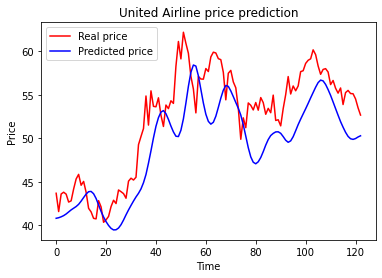

<Figure size 432x288 with 0 Axes>

In [31]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('United Airline price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.savefig('UA_prediction.png')

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cutoff = 0.7                              # decide on a cutoff limit
print(predicted_stock_price)
# y_pred_classes = np.where(predicted_stock_price > 0.5, 1, 0)    # initialise a matrix full with zeros
# print(y_pred_classes)
# y_pred_classes[predicted_stock_price > cutoff] = 1       # add a 1 if the cutoff was breached

# y_test_classes = np.where(real_stock_price > 0.5, 1, 0)
# y_test_classes[real_stock_price > cutoff] = 1

# cf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# print(cf_matrix)
# plt.figure(figsize = (10,7))
# sn.heatmap(cf_matrix, annot=True)

[[40.806694]
 [40.871532]
 [40.977493]
 [41.114334]
 [41.30137 ]
 [41.536945]
 [41.76989 ]
 [41.964333]
 [42.15489 ]
 [42.410343]
 [42.775864]
 [43.188095]
 [43.5838  ]
 [43.861668]
 [43.892   ]
 [43.626   ]
 [43.082306]
 [42.344982]
 [41.598465]
 [40.959618]
 [40.42486 ]
 [39.98524 ]
 [39.651848]
 [39.471634]
 [39.489365]
 [39.68835 ]
 [40.073925]
 [40.605984]
 [41.204674]
 [41.764294]
 [42.2852  ]
 [42.788635]
 [43.257156]
 [43.673496]
 [44.180584]
 [44.890675]
 [45.836586]
 [47.139774]
 [48.557995]
 [50.0381  ]
 [51.36963 ]
 [52.364143]
 [52.999176]
 [53.174953]
 [52.817898]
 [52.15948 ]
 [51.397575]
 [50.72506 ]
 [50.22931 ]
 [50.193344]
 [50.911366]
 [52.226562]
 [54.027718]
 [55.957603]
 [57.569508]
 [58.40689 ]
 [58.2832  ]
 [57.16765 ]
 [55.609203]
 [54.047623]
 [52.754913]
 [51.93622 ]
 [51.617764]
 [51.83128 ]
 [52.52666 ]
 [53.537548]
 [54.60418 ]
 [55.51472 ]
 [56.054203]
 [55.95156 ]
 [55.432148]
 [54.78088 ]
 [54.109325]
 [53.44099 ]
 [52.659554]
 [51.5436  ]
 [50.244267]